In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import nltk
from operator import itemgetter
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import seaborn as sns; sns.set()

In [2]:
# Load data
comic_graph = nx.read_gpickle('../Data/full_graph_directed.pickle')

con_comp = sorted(nx.weakly_connected_components(comic_graph), key = len, reverse = True)
comic_graph_GCC = comic_graph.subgraph(con_comp[0]).copy()

# Part 1: Visualization and Statistics of the Network

## Part 1a: Basic Statistics of the Network

**What is the number of nodes in the network?**

In [3]:
N = len(comic_graph_GCC.nodes())
print(N)

2593


**What is the number of links?**

In [4]:
L = len(comic_graph_GCC.edges())
print(L)

24975


**What is the number of links connecting Marvel and DC? Explain what those links mean?**

In [5]:
marvel_nodes = [superhero for superhero, univserse in nx.get_node_attributes(comic_graph_GCC, 'Universe').items() if univserse == 'Marvel']
dc_nodes = [superhero for superhero, univserse in nx.get_node_attributes(comic_graph_GCC, 'Universe').items() if univserse == 'DC']


In [6]:
num_of_links_between_marvel_dc = []
num_of_links_between_dc_marvel = []

for marvel_node, dc_node in zip(marvel_nodes, dc_nodes):
    edges_from_marvel_node = list(dict(comic_graph_GCC[marvel_node]).keys())
    
    # calculate the number of links between the marvel node and the DC nodes.
    num_of_links_from_marvel_node_to_dc_nodes = sum([edge in dc_nodes for edge in edges_from_marvel_node])
    num_of_links_between_marvel_dc.append(num_of_links_from_marvel_node_to_dc_nodes)
    
    
    edges_from_dc_node = list(dict(comic_graph_GCC[dc_node]).keys())
    num_of_links_from_dc_node_to_marvel_nodes = sum([edge in marvel_nodes for edge in edges_from_dc_node])
    num_of_links_between_dc_marvel.append(num_of_links_from_dc_node_to_marvel_nodes)
    

print(sum(num_of_links_between_marvel_dc))
print(sum(num_of_links_between_dc_marvel))

338
468


**Who are top 5 most connected characters? (Report results for in-degrees and out-degrees).**

In [7]:
dict(sorted(dict(comic_graph_GCC.in_degree).items(), key = itemgetter(1), reverse = True)[:5])

{'Superman': 589,
 'Batman': 574,
 'Spider-Man': 479,
 'Captain America': 430,
 'Iron Man': 355}

In [8]:
dict(sorted(dict(comic_graph_GCC.out_degree).items(), key = itemgetter(1), reverse = True)[:5])

{'Barracuda (II)': 67,
 'Belthera, Queen': 59,
 'Deathstroke': 59,
 'Butcher': 54,
 'Venom': 52}

**Plot the in and out-degree distributions.**

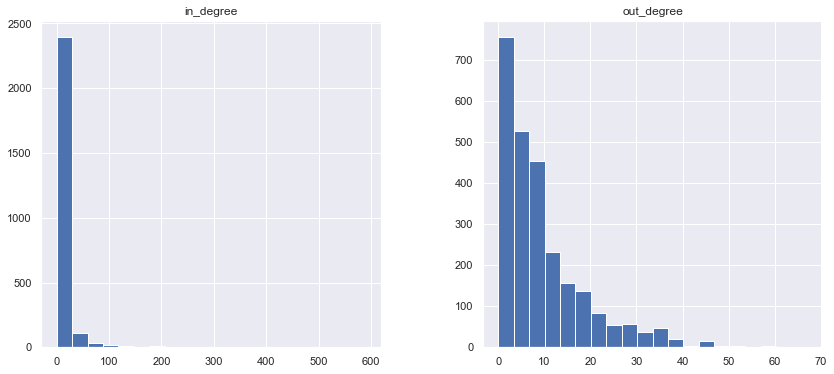

In [9]:
degree_distribution = pd.DataFrame({
    'in_degree' : np.array(list(dict(comic_graph_GCC.in_degree).values())),
    'out_degree' : np.array(list(dict(comic_graph_GCC.out_degree).values()))
})
hist = degree_distribution.hist(bins=20, figsize=(14,6))

Explain what you observe?
Explain why the in-degree distribution is different from the out-degree distribution?

**Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$.**

To initilize the random network with the same number of nodes and probability of connection the average degree is needed. Though the distribution of in degree and out degree are very different for super hero network the average degree is the same. 
$$\langle k_{in} \rangle = \langle k_{out} \rangle$$
This makes good sense good sense as outgoing edge from note is the ingoing edge for another node. This can further be verified by examining the mean of `degree_distribution` dataframe as seen in the cell below. 

In [24]:
degree_distribution.mean()

in_degree     9.631701
out_degree    9.631701
dtype: float64

The average degree of $\langle k_{in} = 9.631701 \rangle$ Can be utilized to calculate the probability that two nodes are connected. From [1, eq. (3.3)] it is know that $\langle k \rangle = p (N-1)$. In this equation $p$ can be isolated and results in the following expression:
$$p = \frac{\langle k \rangle}{N-1}.$$
As the mean, which is $\langle k \rangle$, in the Poisson distribution is equal $\lambda$ the values can easily be inserted and it this specific case it yields:
$$p = \frac{9.631701}{2593} = 0.003714500964.$$

With that number and recalling the GCC contains $N=2593$ nodes we can create the random graph.  

In [11]:
rg = nx.erdos_renyi_graph(n = N, p = 0.003714500964, seed=123, directed=True)

Now we can examine the distribution of in and out degree. As expected the two distributions take the form of Posison distribtuion with mean around $9.63$. 

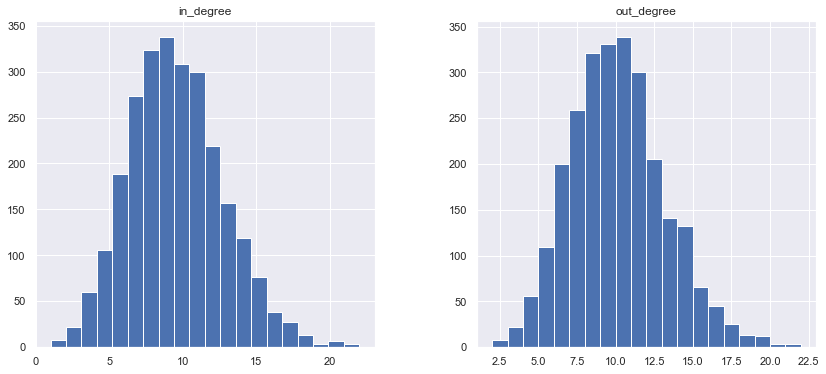

In [12]:
rg_degree_distribution = pd.DataFrame({
    'in_degree' : np.array(list(dict(rg.in_degree).values())),
    'out_degree' : np.array(list(dict(rg.out_degree).values()))
})
hist = rg_degree_distribution.hist(bins=20, figsize=(14,6))

The two graphs, the GCC of super heroes and the random graph, have different distributions because the super hero graph is **not** a random graph.


## Part 1b: Visualization of the Network


**Create a nice visualization of the total network with the following properties**
  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm

In [13]:
comic_graph_GCC_undirected = comic_graph_GCC.to_undirected()

In [14]:
node_colors = ['tab:red' if universe == 'Marvel' else 'tab:blue'  
    for super_hero, universe in nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe').items()]

node_sizes = [degree*2 for degree in dict(comic_graph_GCC_undirected.degree()).values()]

In [15]:
def color_edge(unv1, unv2):
    if unv1 == 'Marvel' and unv2 == 'Marvel':
        color = 'tab:orange'
    elif unv1 == 'DC' and unv2 == 'DC':
        color = 'tab:cyan'
    else:
        color = 'tab:purple'
    return color 

edge_colors = [
    color_edge(*(nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe')[f],
                 nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe')[t]))
    for f, t in comic_graph_GCC_undirected.edges
]

In [22]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    edgeWeightInfluence = 0.5, # Performance

    # Performance
    jitterTolerance=0.2,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,

    # Tuning
    scalingRatio=5.0,
    gravity=1.0,

    # Log
    verbose=True
)


100%|██████████| 2000/2000 [02:46<00:00, 12.00it/s]


BarnesHut Approximation  took  28.79  seconds
Repulsion forces  took  132.32  seconds
Gravitational forces  took  0.31  seconds
Attraction forces  took  1.79  seconds
AdjustSpeedAndApplyForces step  took  1.16  seconds


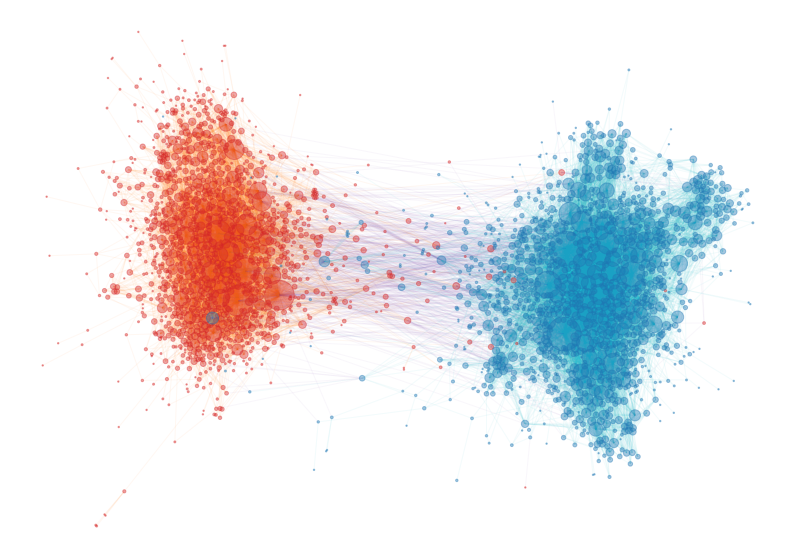

In [23]:
plt.figure(figsize=(14,10))
positions = forceatlas2.forceatlas2_networkx_layout(comic_graph_GCC_undirected, pos=None, iterations=2000)
nx.draw_networkx_nodes(
    G = comic_graph_GCC_undirected,
    node_size = node_sizes,
    pos = positions, 
    node_color=node_colors,
    alpha=0.4
)
nx.draw_networkx_edges(
    G = comic_graph_GCC_undirected,
    pos = positions, 
    edge_color = edge_colors, 
    alpha=0.05
)
plt.axis('off')
plt.show()